In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ======= sklearn =======
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, recall_score
)
# ======= 图像特征库 =======
from skimage.feature import local_binary_pattern

In [2]:
# ======= 参数设置 =======
LBP_METHOD = 'uniform'
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_NEIGHBORS = 5
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

In [3]:
# ======= 1. 加载数据 =======
def load_and_split_dataset(dataset_path, test_size=0.2, sample_ratio=1.0):
    images, labels = [], []
    class_names = sorted(os.listdir(dataset_path))

    for label in class_names:
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir):
            continue
        filenames = sorted(os.listdir(class_dir))
        if sample_ratio < 1.0:
            filenames = filenames[:int(len(filenames) * sample_ratio)]

        for file in filenames:
            img_path = os.path.join(class_dir, file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=RANDOM_STATE, stratify=labels
    )
    return (X_train, y_train), (X_test, y_test), class_names

In [4]:
# ======= 2. LBP 特征提取 =======
def extract_lbp_features(images, radius=1, points=8, method='uniform'):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, points, radius, method)
        hist, _ = np.histogram(
            lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2)
        )
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        features.append(hist)
    return np.array(features)

In [5]:
# ======= 3. 模型评估 =======
def evaluate_model(y_true, y_pred, class_names):
    print("=== Evaluation Results ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Weighted Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("Macro Recall:", recall_score(y_true, y_pred, average='macro'))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', xticklabels=class_names,
                yticklabels=class_names, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [6]:
# ======= 4. 对比展示成功/失败案例 =======
def show_comparison_examples(images, y_true, y_pred, num=5):
    correct = [i for i in range(len(y_true)) if y_true[i] == y_pred[i]]
    wrong = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
    
    total = min(num, len(correct), len(wrong))
    plt.figure(figsize=(15, 4))

    for i in range(total):
        # 成功案例
        idx_c = correct[i]
        plt.subplot(2, total, i + 1)
        plt.imshow(cv2.cvtColor(images[idx_c], cv2.COLOR_BGR2RGB))
        plt.title(f"True: {y_true[idx_c]}\nPred: {y_pred[idx_c]}", fontsize=10)
        plt.axis('off')

        # 失败案例
        idx_w = wrong[i]
        plt.subplot(2, total, total + i + 1)
        plt.imshow(cv2.cvtColor(images[idx_w], cv2.COLOR_BGR2RGB))
        plt.title(f"True: {y_true[idx_w]}\nPred: {y_pred[idx_w]}", fontsize=10)
        plt.axis('off')

    plt.suptitle("Top Row: Correct • Bottom Row: Incorrect Predictions", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

In [7]:
# ======= 5. Ablation: 不同 k =======
def ablation_knn_k_comparison(X_train, y_train, X_test, y_test, class_names, k_list=[4, 6, 8, 10, 12]):
    print("\n=== Ablation Study: Different k in kNN ===")
    for k in k_list:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        macro = recall_score(y_test, y_pred, average='macro')
        weighted = recall_score(y_test, y_pred, average='weighted')
        print(f"k = {k}: Accuracy = {acc:.4f}, Macro Recall = {macro:.4f}, Weighted Recall = {weighted:.4f}")

In [8]:
# ======= 6. Ablation: 不同 LBP 半径 =======
def ablation_lbp_radius_comparison(images, labels, radius_list=[2, 3, 5]):
    print("\n=== Ablation Study: Different LBP Radius ===")
    for radius in radius_list:
        points = radius * 8
        features = extract_lbp_features(images, radius=radius, points=points)
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=TEST_SIZE, stratify=labels)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        macro = recall_score(y_test, y_pred, average='macro')
        weighted = recall_score(y_test, y_pred, average='weighted')
        print(f"Radius = {radius}: Accuracy = {acc:.4f}, Macro Recall = {macro:.4f}, Weighted Recall = {weighted:.4f}")

Training: 9600, Test: 2400

Extracting LBP features...

Training kNN classifier...
=== Evaluation Results ===
Accuracy: 0.53
Weighted Recall: 0.53
Macro Recall: 0.5299999999999999

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.50      0.64      0.56       160
     Airport       0.31      0.35      0.33       160
       Beach       0.43      0.41      0.42       160
        City       0.41      0.50      0.45       160
      Desert       0.57      0.58      0.58       160
      Forest       0.74      0.82      0.78       160
   Grassland       0.75      0.67      0.71       160
     Highway       0.44      0.43      0.44       160
        Lake       0.58      0.51      0.54       160
    Mountain       0.52      0.63      0.57       160
     Parking       0.60      0.48      0.53       160
        Port       0.73      0.68      0.70       160
     Railway       0.52      0.38      0.44       160
 Residential       0.54      0.61      

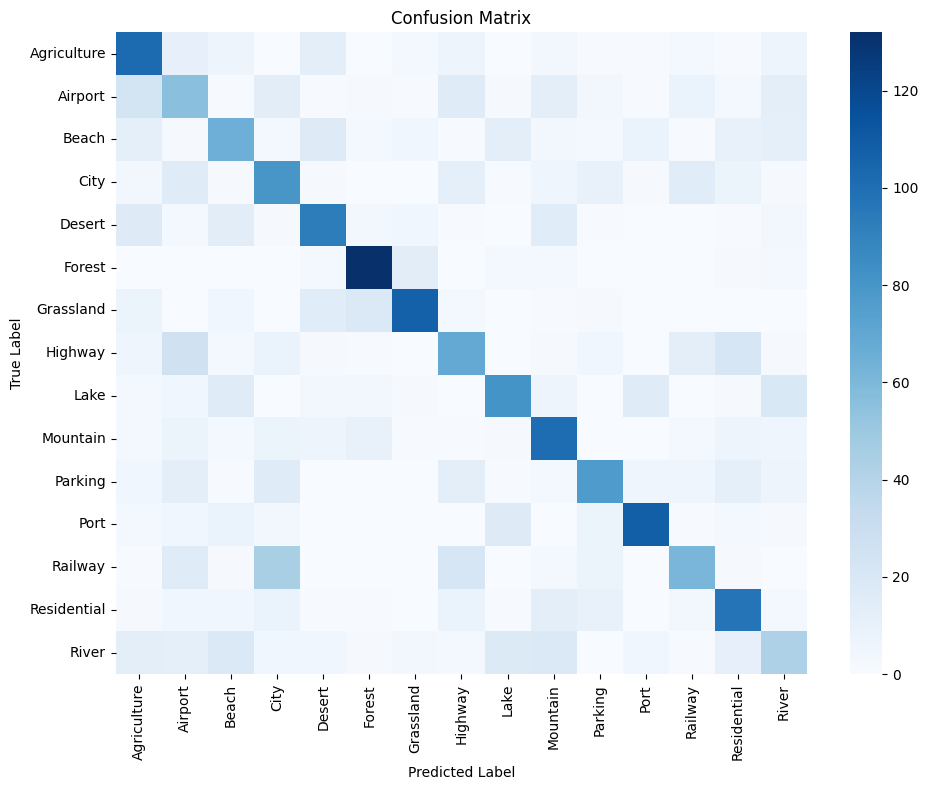


Showing comparison of correct vs incorrect predictions:


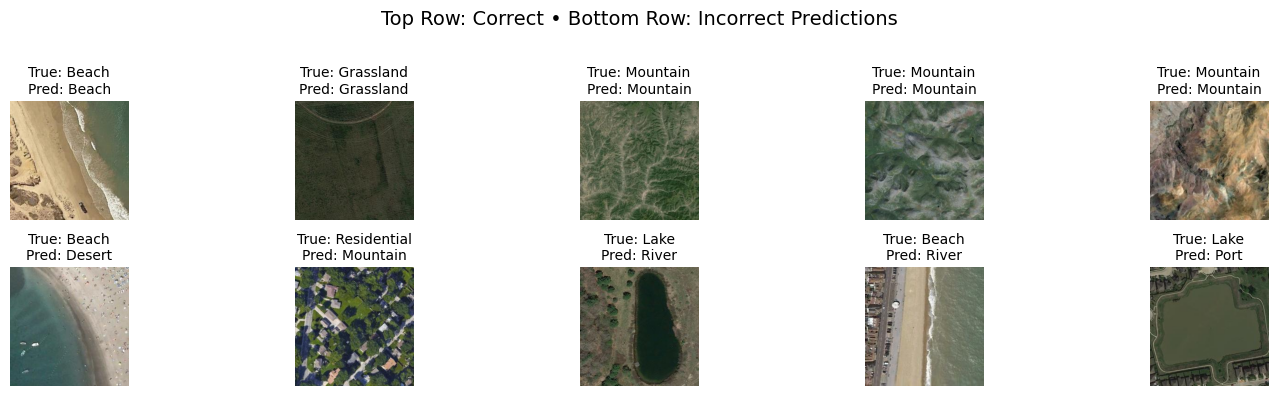


=== Ablation Study: Different k in kNN ===
k = 4: Accuracy = 0.5321, Macro Recall = 0.5321, Weighted Recall = 0.5321
k = 6: Accuracy = 0.5325, Macro Recall = 0.5325, Weighted Recall = 0.5325
k = 8: Accuracy = 0.5413, Macro Recall = 0.5413, Weighted Recall = 0.5413
k = 10: Accuracy = 0.5367, Macro Recall = 0.5367, Weighted Recall = 0.5367
k = 12: Accuracy = 0.5392, Macro Recall = 0.5392, Weighted Recall = 0.5392

=== Ablation Study: Different LBP Radius ===
Radius = 2: Accuracy = 0.5212, Macro Recall = 0.5212, Weighted Recall = 0.5212
Radius = 3: Accuracy = 0.5363, Macro Recall = 0.5363, Weighted Recall = 0.5363
Radius = 5: Accuracy = 0.5325, Macro Recall = 0.5325, Weighted Recall = 0.5325


In [9]:
# ======= 7. 主程序 =======
def main():
    dataset_path = "/kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes"

    (train_images, train_labels), (test_images, test_labels), class_names = load_and_split_dataset(
        dataset_path, test_size=TEST_SIZE
    )
    print(f"Training: {len(train_images)}, Test: {len(test_images)}")

    # 特征提取
    print("\nExtracting LBP features...")
    X_train = extract_lbp_features(train_images, radius=LBP_RADIUS, points=LBP_POINTS)
    X_test = extract_lbp_features(test_images, radius=LBP_RADIUS, points=LBP_POINTS)

    # 标准化
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = np.array(train_labels)
    y_test = np.array(test_labels)

    # 模型训练
    print("\nTraining kNN classifier...")
    clf = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # 模型评估
    evaluate_model(y_test, y_pred, class_names)

    # 展示对比图
    print("\nShowing comparison of correct vs incorrect predictions:")
    show_comparison_examples(test_images, y_test, y_pred, num=5)

    # Ablation: k 对比
    ablation_knn_k_comparison(X_train, y_train, X_test, y_test, class_names)

    # Ablation: LBP radius 对比
    all_images = train_images + test_images
    all_labels = train_labels + test_labels
    ablation_lbp_radius_comparison(all_images, all_labels, radius_list=[2, 3, 5])

# ======= 启动入口 =======
if __name__ == "__main__":
    main()